# Unidad 6 - Actividad 1
# Materia: **Análisis de Algoritmos y Estructuras para Datos Masivos**
# Alumno: **Luis Fernando Izquierdo Berdugo**
# Fecha: **9 de Octubre de 2024**

## Introducción
Esta actividad tiene como objetivo principal **evaluar y comparar** el rendimiento de diferentes algoritmos de intersección de conjuntos. A través de una serie de experimentos, se analizará cómo se comportan estos algoritmos al enfrentarse a conjuntos de datos de distinta complejidad, representados por diferentes combinaciones de listas de posteo.

Para llevar a cabo esta evaluación, se cargará un conjunto inicial de 100 listas de posteo y se generarán subconjuntos de pares, tripletas y tetrapletas de listas. Estos subconjuntos serán la entrada para los algoritmos de intersección, los cuales serán implementados y ejecutados de manera repetida. Los resultados obtenidos en términos de tiempo de ejecución y número de comparaciones se representarán gráficamente para facilitar su análisis y comparación.

Finalmente, se realizará un análisis detallado de los resultados obtenidos, con el fin de identificar patrones, tendencias y evaluar la eficiencia de cada algoritmo en los diferentes escenarios. Este análisis permitirá obtener conclusiones valiosas sobre el comportamiento de los algoritmos de intersección y su aplicabilidad en problemas reales.

## Inciso 1 - Carga y Selección de Listas de Posteo

Lo primero será cargar las listas de posteo en un diccionario.

In [28]:
import numpy as np
import json

def openLists(route):
    val = {}
    with open(f'{route}') as file:
        for line in file:
            data = json.loads(line)
            key, values = data
            val[key] = np.array(values)
        return val
    

archivo = openLists('listas-posteo-100.json')

A continuación se genera una función para generar las diferents combinaciones por medio de la librería `itertools`, para posteriormente hacer una selección aleatoria de 1000 muestras de cada combinación; lo anterior se hace posible con la función `sample`de la librería `random`.

In [29]:
import random
import itertools
listas = list(archivo.values())
# Generamos todas las posibles combinaciones de 3 listas
def generar_combinaciones(listas, n):
    return itertools.combinations(listas, n)

# Seleccionamos aleatoriamente 1000 combinaciones
combinaciones = generar_combinaciones(listas, 2)
A = random.sample(list(combinaciones), 1000)
combinaciones = generar_combinaciones(listas, 3)
B = random.sample(list(combinaciones), 1000)
combinaciones = generar_combinaciones(listas, 4)
C = random.sample(list(combinaciones), 1000)

#print(B)  # Imprime las 1000 combinaciones seleccionadas

## Inciso 2 - Implementación de Algoritmos

Se define el código de la función de `Busqueda Binaria`

In [30]:
def binary_search(arr, x):
  low = 0
  high = len(arr) - 1

  while low <= high:
    mid = (low + high) // 2
    if arr[mid] == x:
      return mid
    elif arr[mid] < x:
      low = mid + 1
    else:
      high = mid - 1

  return -1

Igualmente se define el código de la función de `búsqueda "galloping"`, el cual está basado en el documento "An experimental investigation of set intersection algorithms for text searching. J. Exp. Algorithmics 14, Article 7" de Barbay, et al.

In [31]:
def galloping_search(arr, x):
    # Verificar si la lista está vacía
    if not arr:
        return -1

    # Paso 1: Encontrar el rango donde x podría estar
    if arr[0] == x:
        return 0
    i = 1
    while i < len(arr) and arr[i] < x:
        i = i * 2

    # Paso 2: Realizar una búsqueda binaria en el rango encontrado
    low = i // 2
    high = min(i, len(arr) - 1)
    index = binary_search(arr[low:high+1], x)
    
    # Ajustar el índice si se encontró el elemento
    if index != -1:
        return low + index
    return -1

# Ejemplo de uso
arr = [1, 3, 7, 15, 31, 63, 127, 255, 511, 1023]
x = 63
index = galloping_search(arr, x)
print(f"Elemento {x} encontrado en el índice {index}")

Elemento 63 encontrado en el índice 5


Se genera la función para el algoritmo de intersección `SvS`, basado en el pseudocódigo del documento mencionado previamente; al pseudocódigo se le añadió la funcionalidad de medir el tiempo de procesamiento y el número de comparaciones que se hacen para llegar a cada resultado.

In [32]:
import time

def SvS(sets, k, fbusq):
  start_time = time.process_time()
  comparisons = 0

  # 1. Ordenar los conjuntos por tamaño
  sets.sort(key=len)

  # 2. El conjunto más pequeño es el candidato inicial
  candidate_set = sets[0].copy()

  # 3. Inicializar índices
  indices = [0] * k

  # 4. Iterar sobre los conjuntos
  for i, S in enumerate(sets):
    for e in list(candidate_set):
      # 6. Búsqueda binaria redondeada
      index = fbusq(S[indices[i]:], e)
      comparisons += 1
      if index != -1:
        indices[i] += index + 1
      else:
        # 8-10. Eliminar e del conjunto candidato
        candidate_set.remove(e)
  end_time = time.process_time()
  elapsed_time = end_time - start_time


  return candidate_set, comparisons, elapsed_time

# Ejemplo de uso:
sets = [[1, 2, 3, 4], [3, 4, 9, 10], [3, 4, 5, 6, 7], [3, 4, 11, 12]]
k = len(sets)
result, comparaciones, tiempo = SvS(sets, k, galloping_search)
print(result)  # Output: {3, 4}
print(comparaciones)
print(tiempo)

[3, 4]
12
6.300000001147055e-05


Se implementa el algoritmo `Small Adaptive` con las mismas consideraciones del `SvS`

In [33]:
def SmallAdaptive(sets, k, fbusq):
  start_time = time.process_time()
  comparisons = 0
  answer = []

  # Mientras haya algún conjunto no vacío
  while any(sets):
    # 2. Ordenar los conjuntos por tamaño creciente
    sets.sort(key=len)
    # 3. Seleccionar el primer elemento del conjunto más pequeño como eliminador
    if sets[0]:
        eliminator = sets[0].pop(0)
    else:
        # Si el conjunto está vacío, pasamos al siguiente conjunto
        break

    # 4. Inicializar el índice del conjunto a 1
    elimset = 1

    # 5. Iterar mientras no se hayan revisado todos los conjuntos o se encuentre el eliminador k veces
    while elimset < k and eliminator in sets[elimset]:
      # 6. Búsqueda binaria adaptada para encontrar el eliminador en el conjunto actual
      index = fbusq(sets[elimset], eliminator)
      comparisons += 1
      if index != -1:
        # Eliminar el elemento encontrado y desplazar los elementos restantes
        sets[elimset].pop(index)
      elimset += 1

    # 9. Si se encontró el eliminador en k conjuntos, agregarlo al conjunto de respuestas
    if elimset == k:
      answer.append(eliminator)

  end_time = time.process_time()
  elapsed_time = end_time - start_time

  return answer, comparisons, elapsed_time


sets = [[1, 2, 3, 4], [3, 4, 9, 10], [3, 4, 5, 6, 7], [3, 4, 11, 12]]
k = len(sets)
result, comparaciones, tiempo = SmallAdaptive(sets, k, binary_search)
print(result)  # Output: {3, 4}
print(comparaciones)
print(tiempo)

[3, 4]
6
0.00047699999998940257


La implementación del algoritmo `Sequential` igual involucra la adición del cálculo del tiempo y numero de comparaciones al pseudocódigo.

In [34]:
def Sequential(sets, k, fbusq):
    # Ordenar los conjuntos por tamaño para empezar con el más pequeño
    sets.sort(key=len)
    
    # Inicializar la lista de elementos comunes
    common_elements = []
    comparisons = 0
    
    start_time = time.process_time()
    # Iterar sobre cada elemento del conjunto más pequeño
    for e in sets[0]:
        occurrence_counter = 1  # Contar la ocurrencia en el primer conjunto

        # Verificar si el elemento está presente en todos los demás conjuntos
        for i in range(1, k):
            index = fbusq(sets[i], e)
            comparisons += 1
            if index != -1:
                occurrence_counter += 1
            else:
                break

        # Si el elemento está presente en todos los conjuntos, agregarlo a la lista
        if occurrence_counter == k:
            common_elements.append(e)
    end_time = time.process_time()
    elapsed_time = end_time - start_time
    
    # Devolver la lista de elementos comunes
    return common_elements, comparisons, elapsed_time

# Ejemplo de uso:
sets = [[1, 2, 3, 4, 5, 6], [3, 4, 5,6, 9, 10], [3, 4, 5, 6, 7], [3, 4, 5, 6, 11, 12]]
k = len(sets)
result = Sequential(sets, k, binary_search)
print(result)  # Output: [3, 4, 5]

([3, 4, 5, 6], 13, 3.499999999689862e-05)


Finalmente se implementa el algoritmo de `Baeza-Yates`, el cual divide en dos funciones principales:
- La función `Baeza-Yates` coordina la intersección de múltiples conjuntos ordenados.
- La función `BYintersect` encuntra los elementos comunes entre dos conjuntos ordenados.

De igual manera, en esta función se mide el tiempo y las comparaciones

In [35]:
def BYintersect(setA, setB, minA, maxA, minB, maxB, fbusq, metrics):
    if minA > maxA or minB > maxB:
        return []

    m = (minA + maxA) // 2
    median = setA[m]
    index_in_B = fbusq(setB, median)
    metrics['comparisons'] += 1  # Incrementar el conteo de comparaciones

    result = []
    if index_in_B != -1:
        result.append(median)

    r = index_in_B if index_in_B != -1 else (minB + maxB) // 2

    result += BYintersect(setA, setB, minA, m - 1, minB, r - 1, fbusq, metrics)
    result += BYintersect(setA, setB, m + 1, maxA, r + 1, maxB, fbusq, metrics)

    return result

def BaezaYates(sets, k, fbusq):
    metrics = {'comparisons': 0}
    start_time = time.time()
    sets.sort(key=len)
    candidate = sets[0]

    for i in range(1, k):
        candidate = BYintersect(candidate, sets[i], 0, len(candidate) - 1, 0, len(sets[i]) - 1, fbusq, metrics)
        candidate.sort()

    end_time = time.time()
    elapsed_time = end_time - start_time
    return candidate, metrics['comparisons'], elapsed_time

# Ejemplo de uso
sets = [
    [1, 2, 3, 4, 5],
    [3, 4, 5, 6, 7],
    [5, 6, 7, 8, 9]
]
k = 3

result, comparisons, elapsed_time = BaezaYates(sets, k, binary_search)
print("Resultado:", result)
print("Comparaciones:", comparisons)
print("Tiempo:", elapsed_time)

Resultado: [5]
Comparaciones: 6
Tiempo: 2.9802322387695312e-05


Se creo una función `starter` para ejecutar las diversas pruebas de intersección de manera más sencillas. Esta checa el número de combinaciones para pasarle listas de acuerdo a los conjuntos pares, tripletas y tetrapletas.

In [36]:
def starter(listas, busqueda, interseccion, combs):
    flist = []
    ftime = []
    fcomp = []
    for element in listas:
        if combs == 2:
            lista1 = element[0].tolist()
            lista2 = element[1].tolist()
            listafinal = [lista1, lista2]
        if combs == 3:
            lista1 = element[0].tolist()
            lista2 = element[1].tolist()
            lista3 = element[2].tolist()
            listafinal = [lista1, lista2, lista3]
        if combs == 4:
            lista1 = element[0].tolist()
            lista2 = element[1].tolist()
            lista3 = element[2].tolist()
            lista4 = element[3].tolist()
            listafinal = [lista1, lista2, lista3, lista4]
        k = len(listafinal)
        result, comparaciones, tiempo = interseccion(listafinal, k, busqueda)
        flist.append(result)
        flist = [sublist for sublist in flist if sublist] #Eliminamos las listas vacías
        ftime.append(tiempo)
        fcomp.append(comparaciones)
    return flist, ftime, fcomp


## Inciso 3 - Experimentación y Reporte

Se ejecutan los algoritmos de la siguiente manera:
- SvS con busqueda binaria
- SvS con busqueda galloping
- Small Adaptive con busqueda binaria
- Small Adaptive con busqueda galloping
- Sequential con busqueda binaria
- Sequential con busqueda galloping
- Baeza-Yates con busqueda binaria
- Baeza-Yates con busqueda galloping

In [37]:
lista_svsb_A, comparaciones_svsb_A, tiempo_svsb_A= starter(A, binary_search, SvS, 2)
lista_svsg_A, comparaciones_svsg_A, tiempo_svsg_A = starter(A, galloping_search, SvS, 2)

lista_svsb_B, comparaciones_svsb_B, tiempo_svsb_B = starter(B, binary_search, SvS, 3)
lista_svsg_B, comparaciones_svsg_B, tiempo_svsg_B = starter(B, galloping_search, SvS, 3)

lista_svsb_C, comparaciones_svsb_C, tiempo_svsb_C = starter(C, binary_search, SvS, 4)
lista_svsg_C, comparaciones_svsg_C, tiempo_svsg_C = starter(C, galloping_search, SvS, 4)

In [38]:
lista_sab_A, comparaciones_sab_A, tiempo_sab_A= starter(A, binary_search, SmallAdaptive, 2)
lista_sag_A, comparaciones_sag_A, tiempo_sag_A = starter(A, galloping_search, SmallAdaptive, 2)

lista_sab_B, comparaciones_sab_B, tiempo_sab_B = starter(B, binary_search, SmallAdaptive, 3)
lista_sag_B, comparaciones_sag_B, tiempo_sag_B = starter(B, galloping_search, SmallAdaptive, 3)

lista_sab_C, comparaciones_sab_C, tiempo_sab_C = starter(C, binary_search, SmallAdaptive, 4)
lista_sag_C, comparaciones_sag_C, tiempo_sag_C = starter(C, galloping_search, SmallAdaptive, 4)

In [39]:
lista_seqb_A, comparaciones_seqb_A, tiempo_seqb_A, = starter(A, binary_search, Sequential, 2)
lista_seqg_A, comparaciones_seqg_A, tiempo_seqg_A = starter(A, galloping_search, Sequential, 2)

lista_seqb_B, comparaciones_seqb_B, tiempo_seqb_B = starter(B, binary_search, Sequential, 3)
lista_seqg_B, comparaciones_seqg_B, tiempo_seqg_B = starter(B, galloping_search, Sequential, 3)

lista_seqb_C, comparaciones_seqb_C, tiempo_seqb_C = starter(C, binary_search, Sequential, 4)
lista_seqg_C, comparaciones_seqg_C, tiempo_seqg_C = starter(C, galloping_search, Sequential, 4)

In [40]:
lista_bayb_A, comparaciones_bayb_A, tiempo_bayb_A, = starter(A, binary_search, BaezaYates, 2)
lista_bayg_A, comparaciones_bayg_A, tiempo_bayg_A = starter(A, galloping_search, BaezaYates, 2)

lista_bayb_B, comparaciones_bayb_B, tiempo_bayb_B = starter(B, binary_search, BaezaYates, 3)
lista_bayg_B, comparaciones_bayg_B, tiempo_bayg_B = starter(B, galloping_search, BaezaYates, 3)

lista_bayb_C, comparaciones_bayb_C, tiempo_bayb_C = starter(C, binary_search, BaezaYates, 4)
lista_bayg_C, comparaciones_bayg_C, tiempo_bayg_C = starter(C, galloping_search, BaezaYates, 4)

Las funciones devuelven una lista de listas de los elementos intersecados, por lo cual se creó una función `convertir_a_longitudes` para generar una lista con las longitudes de estos elementos.

In [41]:
# Función para convertir listas en listas de longitudes
def convertir_a_longitudes(lista):
    return [len(sublista) for sublista in lista]

# Convertir las listas
longitudes_svsb_A = convertir_a_longitudes(lista_svsb_A)
longitudes_svsg_A = convertir_a_longitudes(lista_svsg_A)
longitudes_svsb_B = convertir_a_longitudes(lista_svsb_B)
longitudes_svsg_B = convertir_a_longitudes(lista_svsg_B)
longitudes_svsb_C = convertir_a_longitudes(lista_svsb_C)
longitudes_svsg_C = convertir_a_longitudes(lista_svsg_C)

longitudes_sab_A = convertir_a_longitudes(lista_sab_A)
longitudes_sag_A = convertir_a_longitudes(lista_sag_A)
longitudes_sab_B = convertir_a_longitudes(lista_sab_B)
longitudes_sag_B = convertir_a_longitudes(lista_sag_B)
longitudes_sab_C = convertir_a_longitudes(lista_sab_C)
longitudes_sag_C = convertir_a_longitudes(lista_sag_C)

longitudes_seqb_A = convertir_a_longitudes(lista_seqb_A)
longitudes_seqg_A = convertir_a_longitudes(lista_seqg_A)
longitudes_seqb_B = convertir_a_longitudes(lista_seqb_B)
longitudes_seqg_B = convertir_a_longitudes(lista_seqg_B)
longitudes_seqb_C = convertir_a_longitudes(lista_seqb_C)
longitudes_seqg_C = convertir_a_longitudes(lista_seqg_C)

longitudes_bayb_A = convertir_a_longitudes(lista_bayb_A)
longitudes_bayg_A = convertir_a_longitudes(lista_bayg_A)
longitudes_bayb_B = convertir_a_longitudes(lista_bayb_B)
longitudes_bayg_B = convertir_a_longitudes(lista_bayg_B)
longitudes_bayb_C = convertir_a_longitudes(lista_bayb_C)
longitudes_bayg_C = convertir_a_longitudes(lista_bayg_C)

## Inciso 4 - Análisis de Resultados
Para iniciar con el análisis de resultados, se crearon grids de gráficas boxplots para analizar correctamente los diferentes conjuntos de listas, algoritmos de intersección y algoritmos de búsqueda, todo esto con la librería `matplotlib`.
Se generaron dos grids para cada métrica (longitudes, tiempo y comparaciones), un gridbox no muestra los outliers, para observar mejor las cajas y el otro si muestra los outliers.

/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/1599116265.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(longitudes_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=False)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/1599116265.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(longitudes_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=False)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/1599116265.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1, 0].boxpl

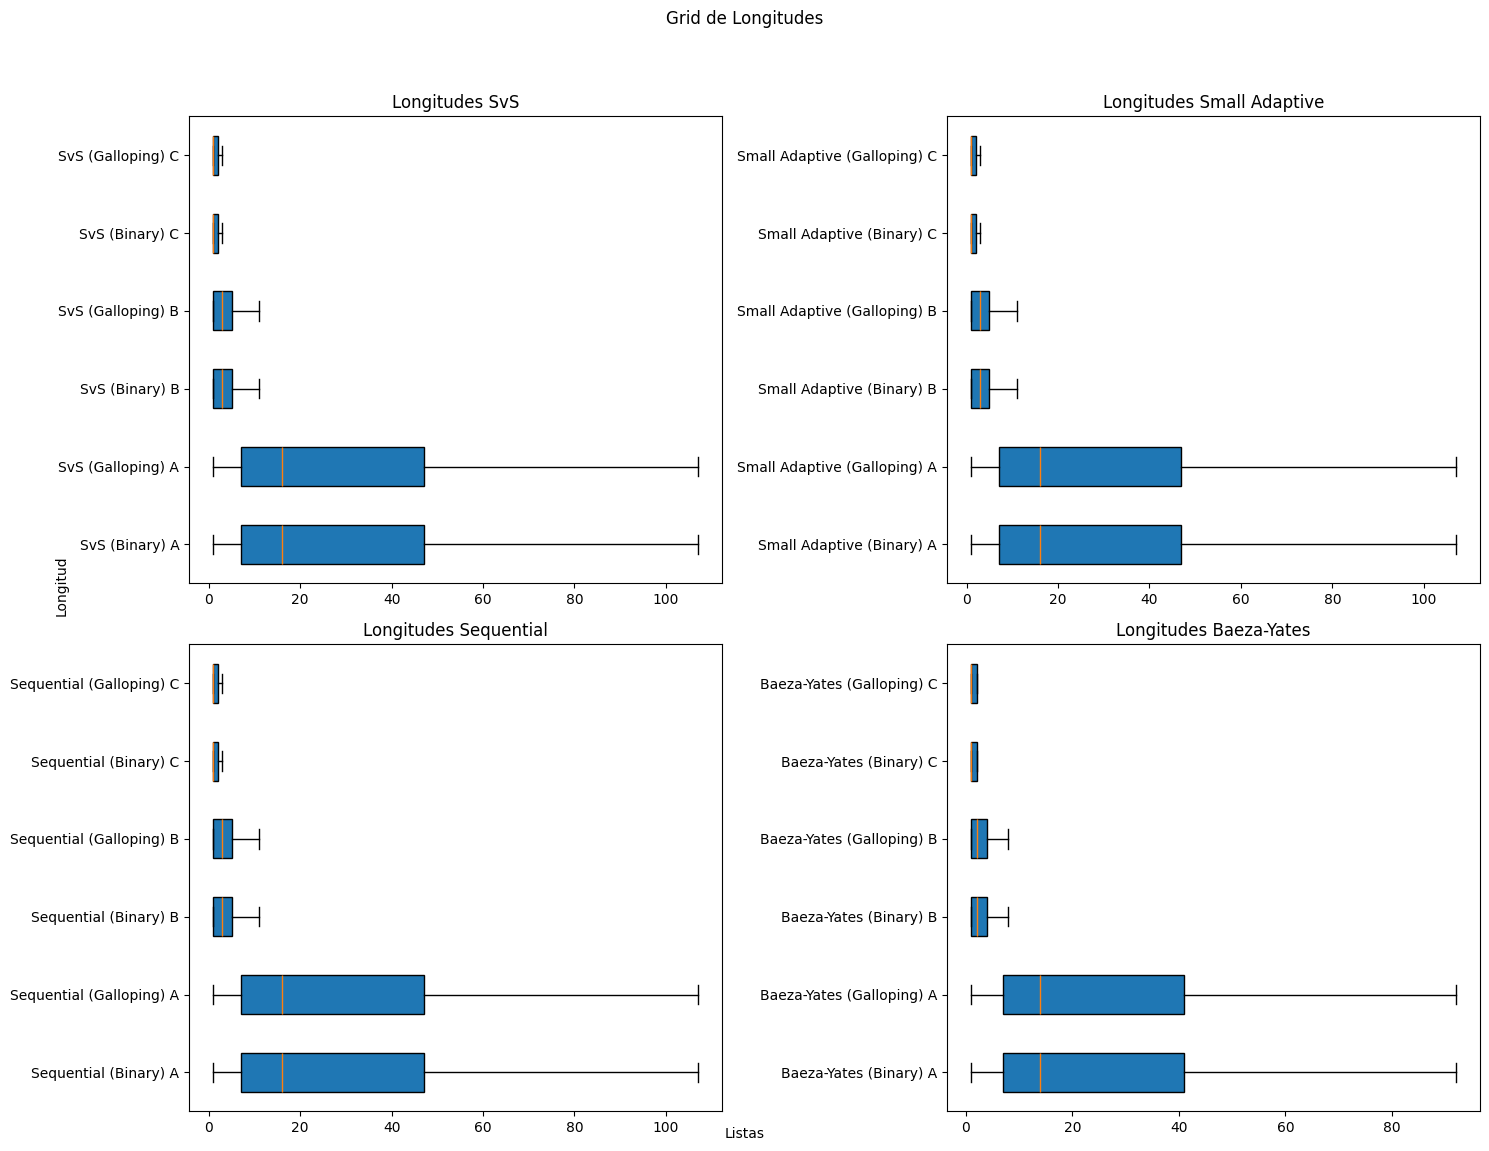

In [42]:
import matplotlib.pyplot as plt

# Datos
longitudes_svs = [longitudes_svsb_A, longitudes_svsg_A, longitudes_svsb_B, longitudes_svsg_B, longitudes_svsb_C, longitudes_svsg_C]
longitudes_small_adaptive = [longitudes_sab_A, longitudes_sag_A, longitudes_sab_B, longitudes_sag_B, longitudes_sab_C, longitudes_sag_C]
longitudes_sequential = [longitudes_seqb_A, longitudes_seqg_A, longitudes_seqb_B, longitudes_seqg_B, longitudes_seqb_C, longitudes_seqg_C]
longitudes_baezayates = [longitudes_bayb_A, longitudes_bayg_A, longitudes_bayb_B, longitudes_bayg_B, longitudes_bayb_C, longitudes_bayg_C]

# Etiquetas para cada conjunto de datos
labels_svs = ['SvS (Binary) A', 'SvS (Galloping) A', 'SvS (Binary) B', 'SvS (Galloping) B', 'SvS (Binary) C', 'SvS (Galloping) C']
labels_small_adaptive = ['Small Adaptive (Binary) A', 'Small Adaptive (Galloping) A', 'Small Adaptive (Binary) B', 'Small Adaptive (Galloping) B', 'Small Adaptive (Binary) C', 'Small Adaptive (Galloping) C']
labels_sequential = ['Sequential (Binary) A', 'Sequential (Galloping) A', 'Sequential (Binary) B', 'Sequential (Galloping) B', 'Sequential (Binary) C', 'Sequential (Galloping) C']
labels_baezayates = ['Baeza-Yates (Binary) A', 'Baeza-Yates (Galloping) A', 'Baeza-Yates (Binary) B', 'Baeza-Yates (Galloping) B', 'Baeza-Yates (Binary) C', 'Baeza-Yates (Galloping) C']

# Crear el grid de subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Añadir boxplots a cada subplot
axs[0, 0].boxplot(longitudes_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=False)
axs[0, 0].set_title('Longitudes SvS')

axs[0, 1].boxplot(longitudes_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=False)
axs[0, 1].set_title('Longitudes Small Adaptive')

axs[1, 0].boxplot(longitudes_sequential, vert=False, patch_artist=True, labels=labels_sequential, showfliers=False)
axs[1, 0].set_title('Longitudes Sequential')

axs[1, 1].boxplot(longitudes_baezayates, vert=False, patch_artist=True, labels=labels_baezayates, showfliers=False)
axs[1, 1].set_title('Longitudes Baeza-Yates')

# Añadir etiquetas comunes
fig.suptitle('Grid de Longitudes')
fig.text(0.5, 0.04, 'Listas', ha='center')
fig.text(0.04, 0.5, 'Longitud', va='center', rotation='vertical')

# Ajustar el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar el gráfico
plt.show()

/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/203393723.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(longitudes_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=True)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/203393723.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(longitudes_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=True)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/203393723.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1, 0].boxplot(lo

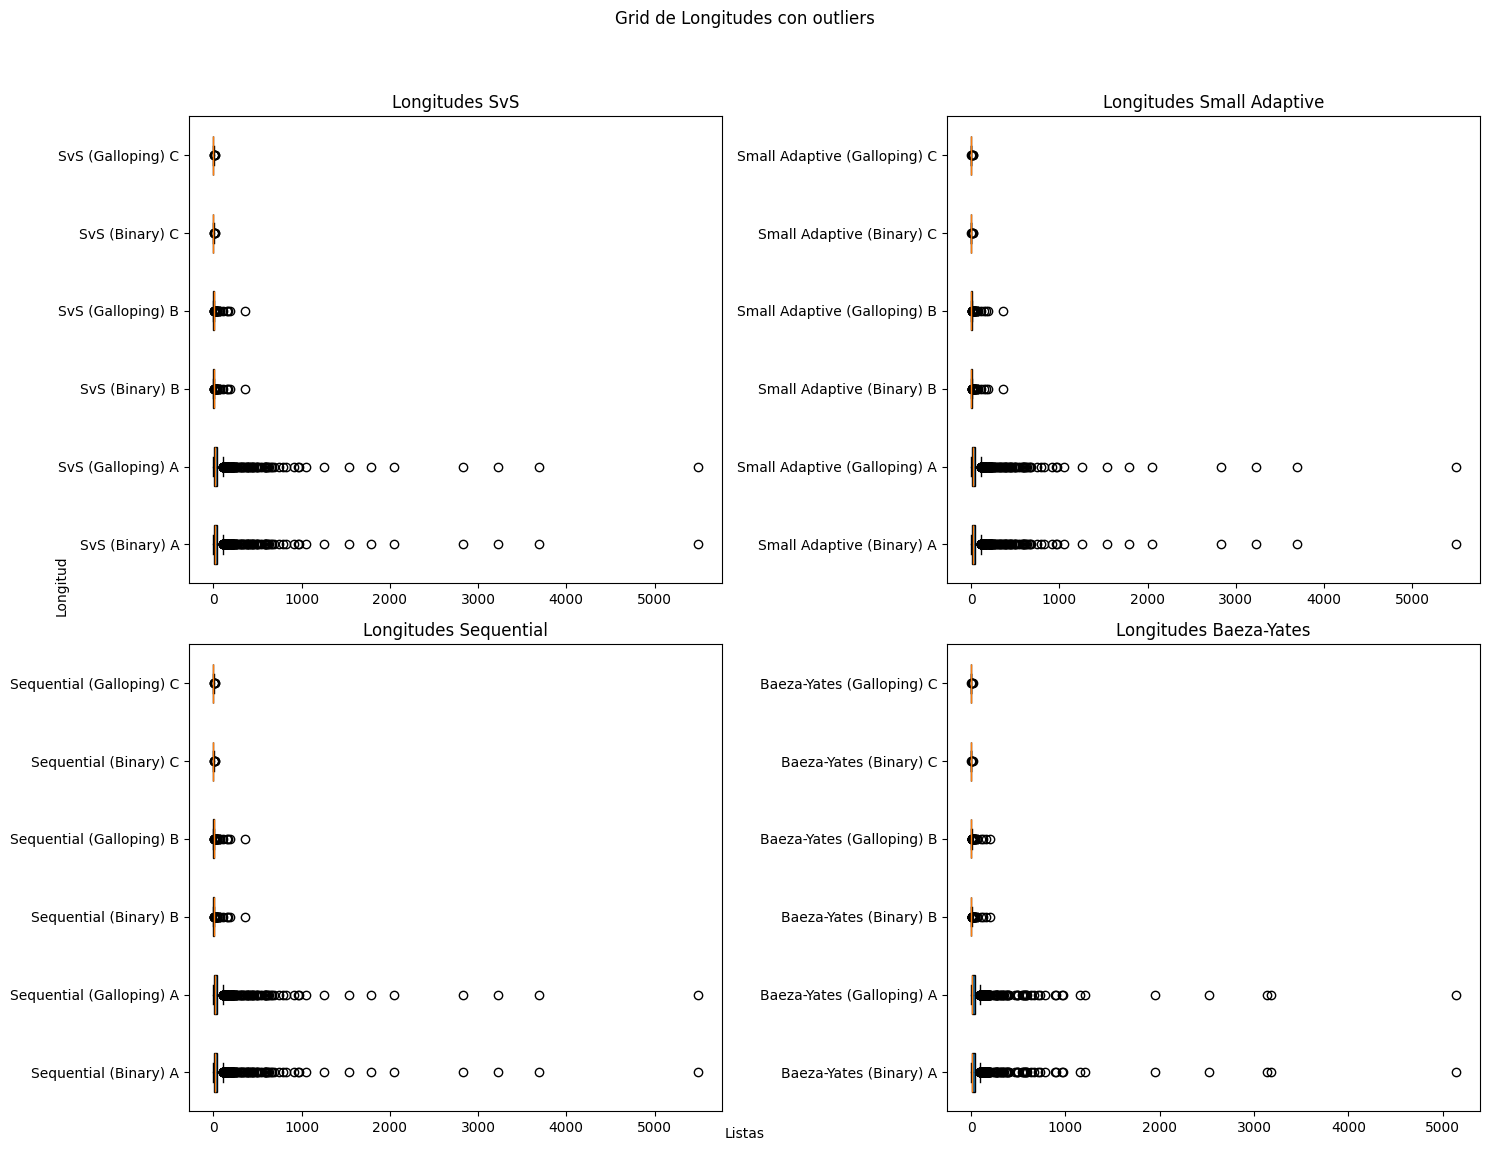

In [43]:
# Datos
longitudes_svs = [longitudes_svsb_A, longitudes_svsg_A, longitudes_svsb_B, longitudes_svsg_B, longitudes_svsb_C, longitudes_svsg_C]
longitudes_small_adaptive = [longitudes_sab_A, longitudes_sag_A, longitudes_sab_B, longitudes_sag_B, longitudes_sab_C, longitudes_sag_C]
longitudes_sequential = [longitudes_seqb_A, longitudes_seqg_A, longitudes_seqb_B, longitudes_seqg_B, longitudes_seqb_C, longitudes_seqg_C]
longitudes_baezayates = [longitudes_bayb_A, longitudes_bayg_A, longitudes_bayb_B, longitudes_bayg_B, longitudes_bayb_C, longitudes_bayg_C]

# Etiquetas para cada conjunto de datos
labels_svs = ['SvS (Binary) A', 'SvS (Galloping) A', 'SvS (Binary) B', 'SvS (Galloping) B', 'SvS (Binary) C', 'SvS (Galloping) C']
labels_small_adaptive = ['Small Adaptive (Binary) A', 'Small Adaptive (Galloping) A', 'Small Adaptive (Binary) B', 'Small Adaptive (Galloping) B', 'Small Adaptive (Binary) C', 'Small Adaptive (Galloping) C']
labels_sequential = ['Sequential (Binary) A', 'Sequential (Galloping) A', 'Sequential (Binary) B', 'Sequential (Galloping) B', 'Sequential (Binary) C', 'Sequential (Galloping) C']
labels_baezayates = ['Baeza-Yates (Binary) A', 'Baeza-Yates (Galloping) A', 'Baeza-Yates (Binary) B', 'Baeza-Yates (Galloping) B', 'Baeza-Yates (Binary) C', 'Baeza-Yates (Galloping) C']

# Crear el grid de subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Añadir boxplots a cada subplot
axs[0, 0].boxplot(longitudes_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=True)
axs[0, 0].set_title('Longitudes SvS')

axs[0, 1].boxplot(longitudes_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=True)
axs[0, 1].set_title('Longitudes Small Adaptive')

axs[1, 0].boxplot(longitudes_sequential, vert=False, patch_artist=True, labels=labels_sequential, showfliers=True)
axs[1, 0].set_title('Longitudes Sequential')

axs[1, 1].boxplot(longitudes_baezayates, vert=False, patch_artist=True, labels=labels_baezayates, showfliers=True)
axs[1, 1].set_title('Longitudes Baeza-Yates')

# Añadir etiquetas comunes
fig.suptitle('Grid de Longitudes con outliers')
fig.text(0.5, 0.04, 'Listas', ha='center')
fig.text(0.04, 0.5, 'Longitud', va='center', rotation='vertical')

# Ajustar el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar el gráfico
plt.show()

/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/1491468498.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(tiempos_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=False)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/1491468498.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(tiempos_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=False)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/1491468498.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1, 0].boxplot(tie

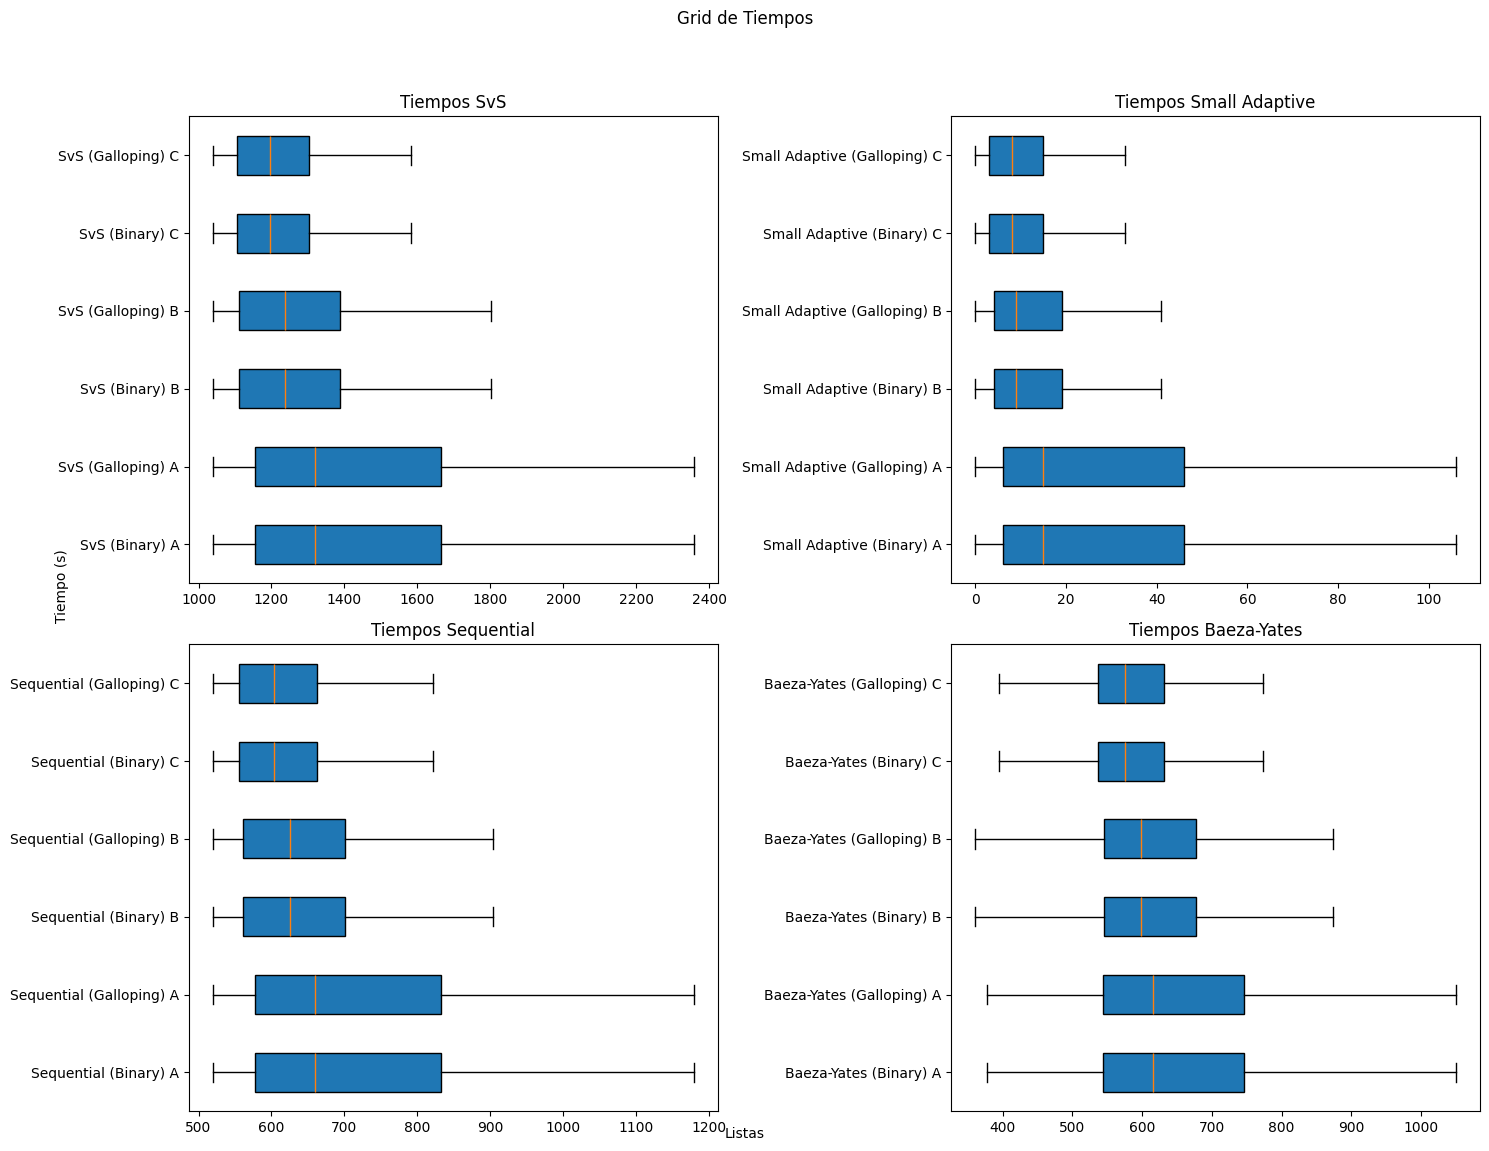

In [44]:
# Datos de tiempos
tiempos_svs = [tiempo_svsb_A, tiempo_svsg_A, tiempo_svsb_B, tiempo_svsg_B, tiempo_svsb_C, tiempo_svsg_C]
tiempos_small_adaptive = [tiempo_sab_A, tiempo_sag_A, tiempo_sab_B, tiempo_sag_B, tiempo_sab_C, tiempo_sag_C]
tiempos_sequential = [tiempo_seqb_A, tiempo_seqg_A, tiempo_seqb_B, tiempo_seqg_B, tiempo_seqb_C, tiempo_seqg_C]
tiempos_baezayates = [tiempo_bayb_A, tiempo_bayg_A, tiempo_bayb_B, tiempo_bayg_B, tiempo_bayb_C, tiempo_bayg_C]

# Etiquetas para cada conjunto de datos
labels_svs = ['SvS (Binary) A', 'SvS (Galloping) A', 'SvS (Binary) B', 'SvS (Galloping) B', 'SvS (Binary) C', 'SvS (Galloping) C']
labels_small_adaptive = ['Small Adaptive (Binary) A', 'Small Adaptive (Galloping) A', 'Small Adaptive (Binary) B', 'Small Adaptive (Galloping) B', 'Small Adaptive (Binary) C', 'Small Adaptive (Galloping) C']
labels_sequential = ['Sequential (Binary) A', 'Sequential (Galloping) A', 'Sequential (Binary) B', 'Sequential (Galloping) B', 'Sequential (Binary) C', 'Sequential (Galloping) C']
labels_baezayates = ['Baeza-Yates (Binary) A', 'Baeza-Yates (Galloping) A', 'Baeza-Yates (Binary) B', 'Baeza-Yates (Galloping) B', 'Baeza-Yates (Binary) C', 'Baeza-Yates (Galloping) C']

# Crear el grid de subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Añadir boxplots a cada subplot
axs[0, 0].boxplot(tiempos_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=False)
axs[0, 0].set_title('Tiempos SvS')

axs[0, 1].boxplot(tiempos_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=False)
axs[0, 1].set_title('Tiempos Small Adaptive')

axs[1, 0].boxplot(tiempos_sequential, vert=False, patch_artist=True, labels=labels_sequential, showfliers=False)
axs[1, 0].set_title('Tiempos Sequential')

axs[1, 1].boxplot(tiempos_baezayates, vert=False, patch_artist=True, labels=labels_baezayates, showfliers=False)
axs[1, 1].set_title('Tiempos Baeza-Yates')

# Añadir etiquetas comunes
fig.suptitle('Grid de Tiempos')
fig.text(0.5, 0.04, 'Listas', ha='center')
fig.text(0.04, 0.5, 'Tiempo (s)', va='center', rotation='vertical')

# Ajustar el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar el gráfico
plt.show()

/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/3449886027.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(tiempos_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=True)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/3449886027.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(tiempos_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=True)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/3449886027.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1, 0].boxplot(tiemp

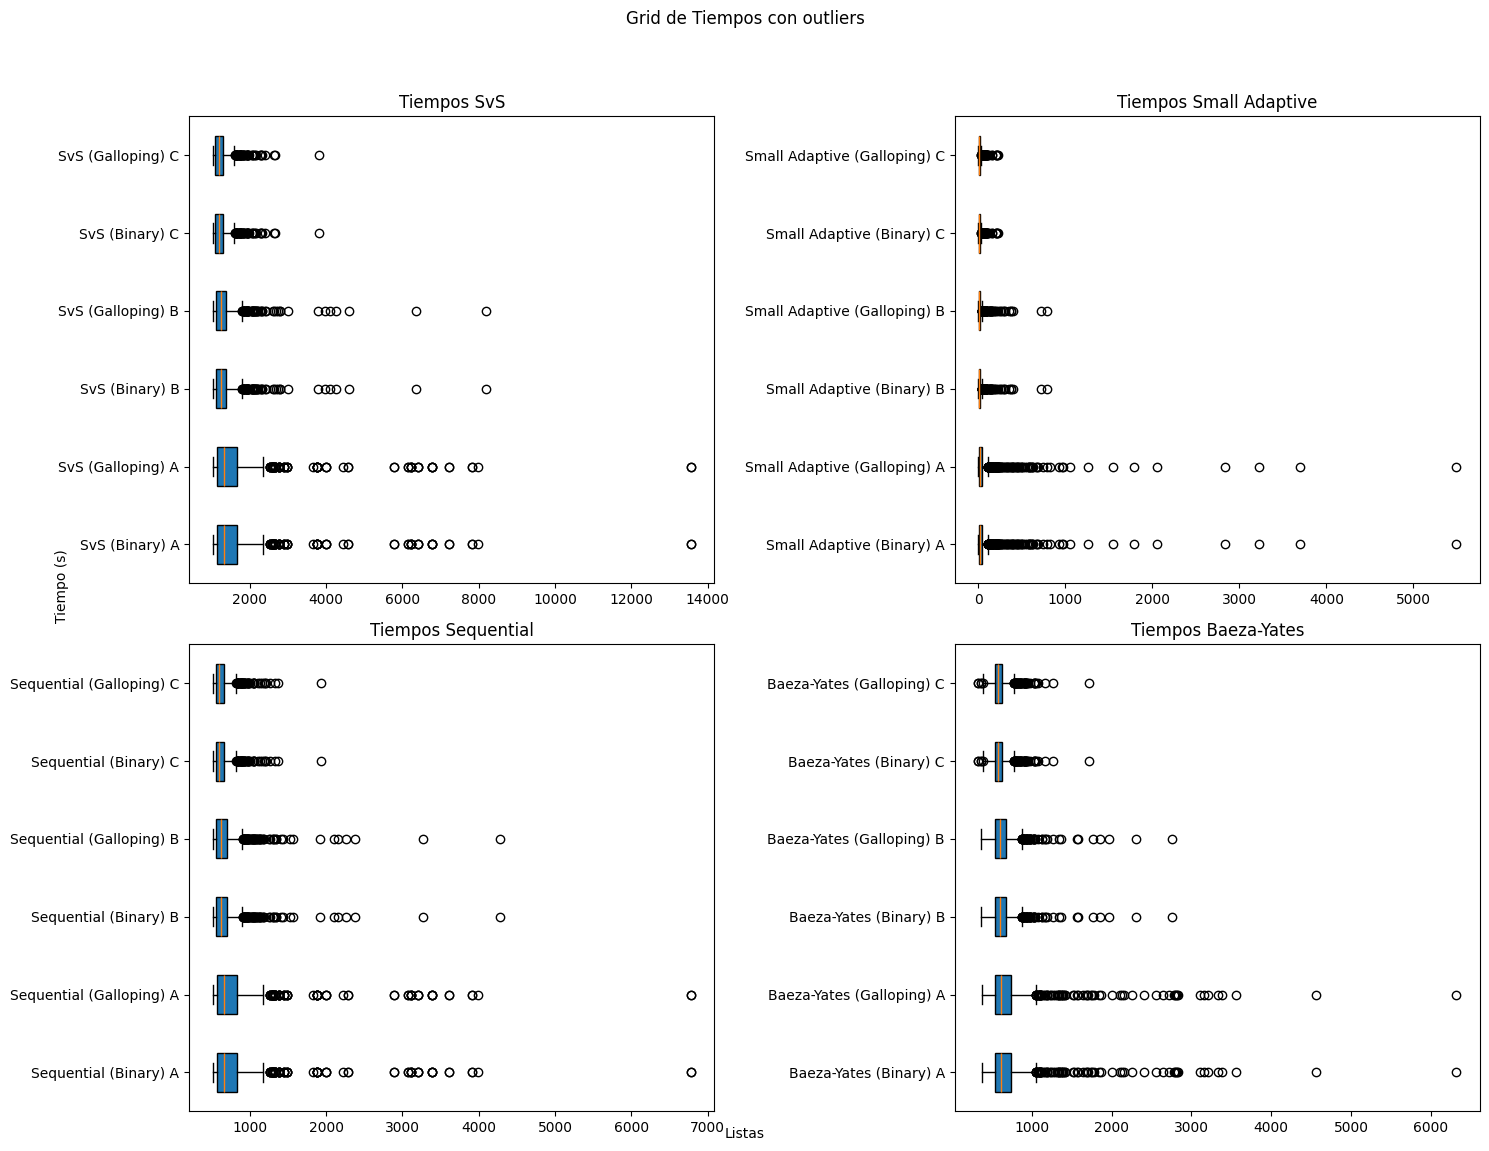

In [45]:
# Datos de tiempos
tiempos_svs = [tiempo_svsb_A, tiempo_svsg_A, tiempo_svsb_B, tiempo_svsg_B, tiempo_svsb_C, tiempo_svsg_C]
tiempos_small_adaptive = [tiempo_sab_A, tiempo_sag_A, tiempo_sab_B, tiempo_sag_B, tiempo_sab_C, tiempo_sag_C]
tiempos_sequential = [tiempo_seqb_A, tiempo_seqg_A, tiempo_seqb_B, tiempo_seqg_B, tiempo_seqb_C, tiempo_seqg_C]
tiempos_baezayates = [tiempo_bayb_A, tiempo_bayg_A, tiempo_bayb_B, tiempo_bayg_B, tiempo_bayb_C, tiempo_bayg_C]

# Etiquetas para cada conjunto de datos
labels_svs = ['SvS (Binary) A', 'SvS (Galloping) A', 'SvS (Binary) B', 'SvS (Galloping) B', 'SvS (Binary) C', 'SvS (Galloping) C']
labels_small_adaptive = ['Small Adaptive (Binary) A', 'Small Adaptive (Galloping) A', 'Small Adaptive (Binary) B', 'Small Adaptive (Galloping) B', 'Small Adaptive (Binary) C', 'Small Adaptive (Galloping) C']
labels_sequential = ['Sequential (Binary) A', 'Sequential (Galloping) A', 'Sequential (Binary) B', 'Sequential (Galloping) B', 'Sequential (Binary) C', 'Sequential (Galloping) C']
labels_baezayates = ['Baeza-Yates (Binary) A', 'Baeza-Yates (Galloping) A', 'Baeza-Yates (Binary) B', 'Baeza-Yates (Galloping) B', 'Baeza-Yates (Binary) C', 'Baeza-Yates (Galloping) C']

# Crear el grid de subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Añadir boxplots a cada subplot
axs[0, 0].boxplot(tiempos_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=True)
axs[0, 0].set_title('Tiempos SvS')

axs[0, 1].boxplot(tiempos_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=True)
axs[0, 1].set_title('Tiempos Small Adaptive')

axs[1, 0].boxplot(tiempos_sequential, vert=False, patch_artist=True, labels=labels_sequential, showfliers=True)
axs[1, 0].set_title('Tiempos Sequential')

axs[1, 1].boxplot(tiempos_baezayates, vert=False, patch_artist=True, labels=labels_baezayates, showfliers=True)
axs[1, 1].set_title('Tiempos Baeza-Yates')

# Añadir etiquetas comunes
fig.suptitle('Grid de Tiempos con outliers')
fig.text(0.5, 0.04, 'Listas', ha='center')
fig.text(0.04, 0.5, 'Tiempo (s)', va='center', rotation='vertical')

# Ajustar el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar el gráfico
plt.show()

/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/2875603122.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(comparaciones_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=False)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/2875603122.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(comparaciones_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=False)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/2875603122.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1, 0]

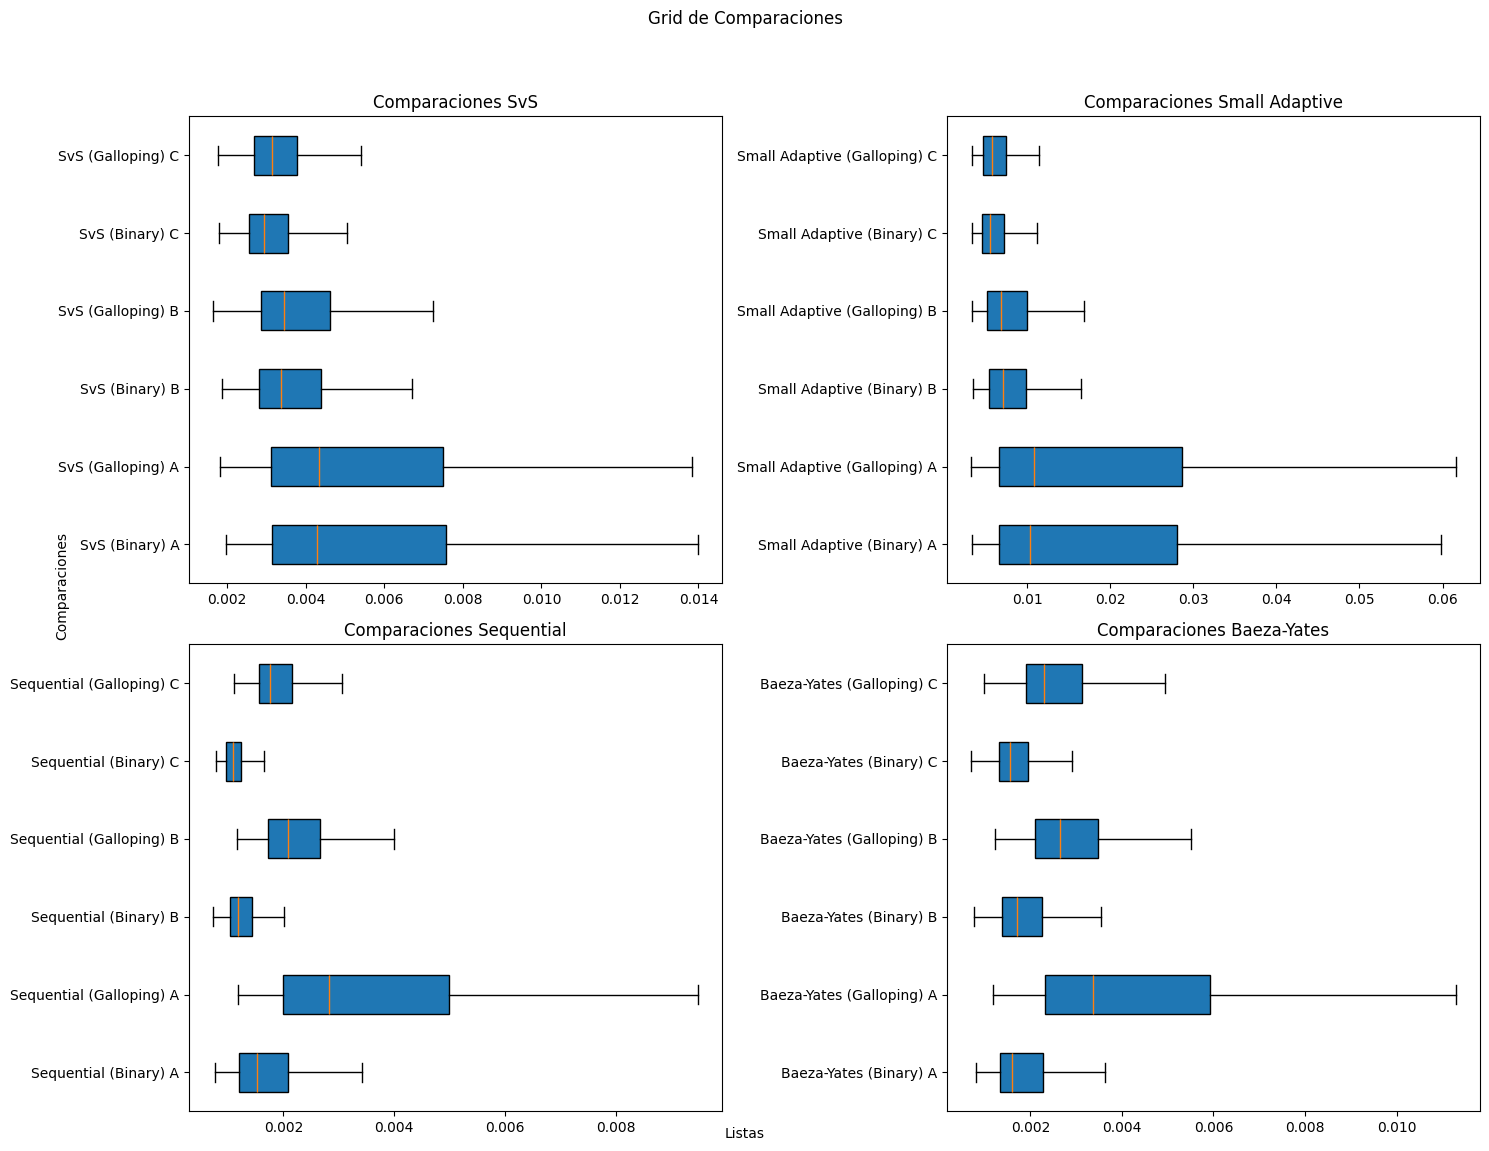

In [46]:
# Datos de comparaciones
comparaciones_svs = [comparaciones_svsb_A, comparaciones_svsg_A, comparaciones_svsb_B, comparaciones_svsg_B, comparaciones_svsb_C, comparaciones_svsg_C]
comparaciones_small_adaptive = [comparaciones_sab_A, comparaciones_sag_A, comparaciones_sab_B, comparaciones_sag_B, comparaciones_sab_C, comparaciones_sag_C]
comparaciones_sequential = [comparaciones_seqb_A, comparaciones_seqg_A, comparaciones_seqb_B, comparaciones_seqg_B, comparaciones_seqb_C, comparaciones_seqg_C]
comparaciones_baezayates = [comparaciones_bayb_A, comparaciones_bayg_A, comparaciones_bayb_B, comparaciones_bayg_B, comparaciones_bayb_C, comparaciones_bayg_C]

# Etiquetas para cada conjunto de datos
labels_svs = ['SvS (Binary) A', 'SvS (Galloping) A', 'SvS (Binary) B', 'SvS (Galloping) B', 'SvS (Binary) C', 'SvS (Galloping) C']
labels_small_adaptive = ['Small Adaptive (Binary) A', 'Small Adaptive (Galloping) A', 'Small Adaptive (Binary) B', 'Small Adaptive (Galloping) B', 'Small Adaptive (Binary) C', 'Small Adaptive (Galloping) C']
labels_sequential = ['Sequential (Binary) A', 'Sequential (Galloping) A', 'Sequential (Binary) B', 'Sequential (Galloping) B', 'Sequential (Binary) C', 'Sequential (Galloping) C']
labels_baezayates = ['Baeza-Yates (Binary) A', 'Baeza-Yates (Galloping) A', 'Baeza-Yates (Binary) B', 'Baeza-Yates (Galloping) B', 'Baeza-Yates (Binary) C', 'Baeza-Yates (Galloping) C']

# Crear el grid de subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Añadir boxplots a cada subplot
axs[0, 0].boxplot(comparaciones_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=False)
axs[0, 0].set_title('Comparaciones SvS')

axs[0, 1].boxplot(comparaciones_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=False)
axs[0, 1].set_title('Comparaciones Small Adaptive')

axs[1, 0].boxplot(comparaciones_sequential, vert=False, patch_artist=True, labels=labels_sequential, showfliers=False)
axs[1, 0].set_title('Comparaciones Sequential')

axs[1, 1].boxplot(comparaciones_baezayates, vert=False, patch_artist=True, labels=labels_baezayates, showfliers=False)
axs[1, 1].set_title('Comparaciones Baeza-Yates')

# Añadir etiquetas comunes
fig.suptitle('Grid de Comparaciones')
fig.text(0.5, 0.04, 'Listas', ha='center')
fig.text(0.04, 0.5, 'Comparaciones', va='center', rotation='vertical')

# Ajustar el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar el gráfico
plt.show()

/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/3633175240.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 0].boxplot(comparaciones_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=True)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/3633175240.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0, 1].boxplot(comparaciones_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=True)
/var/folders/v3/6n107fw10yb9ryc5t5mmqw5c0000gp/T/ipykernel_9738/3633175240.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1, 0].b

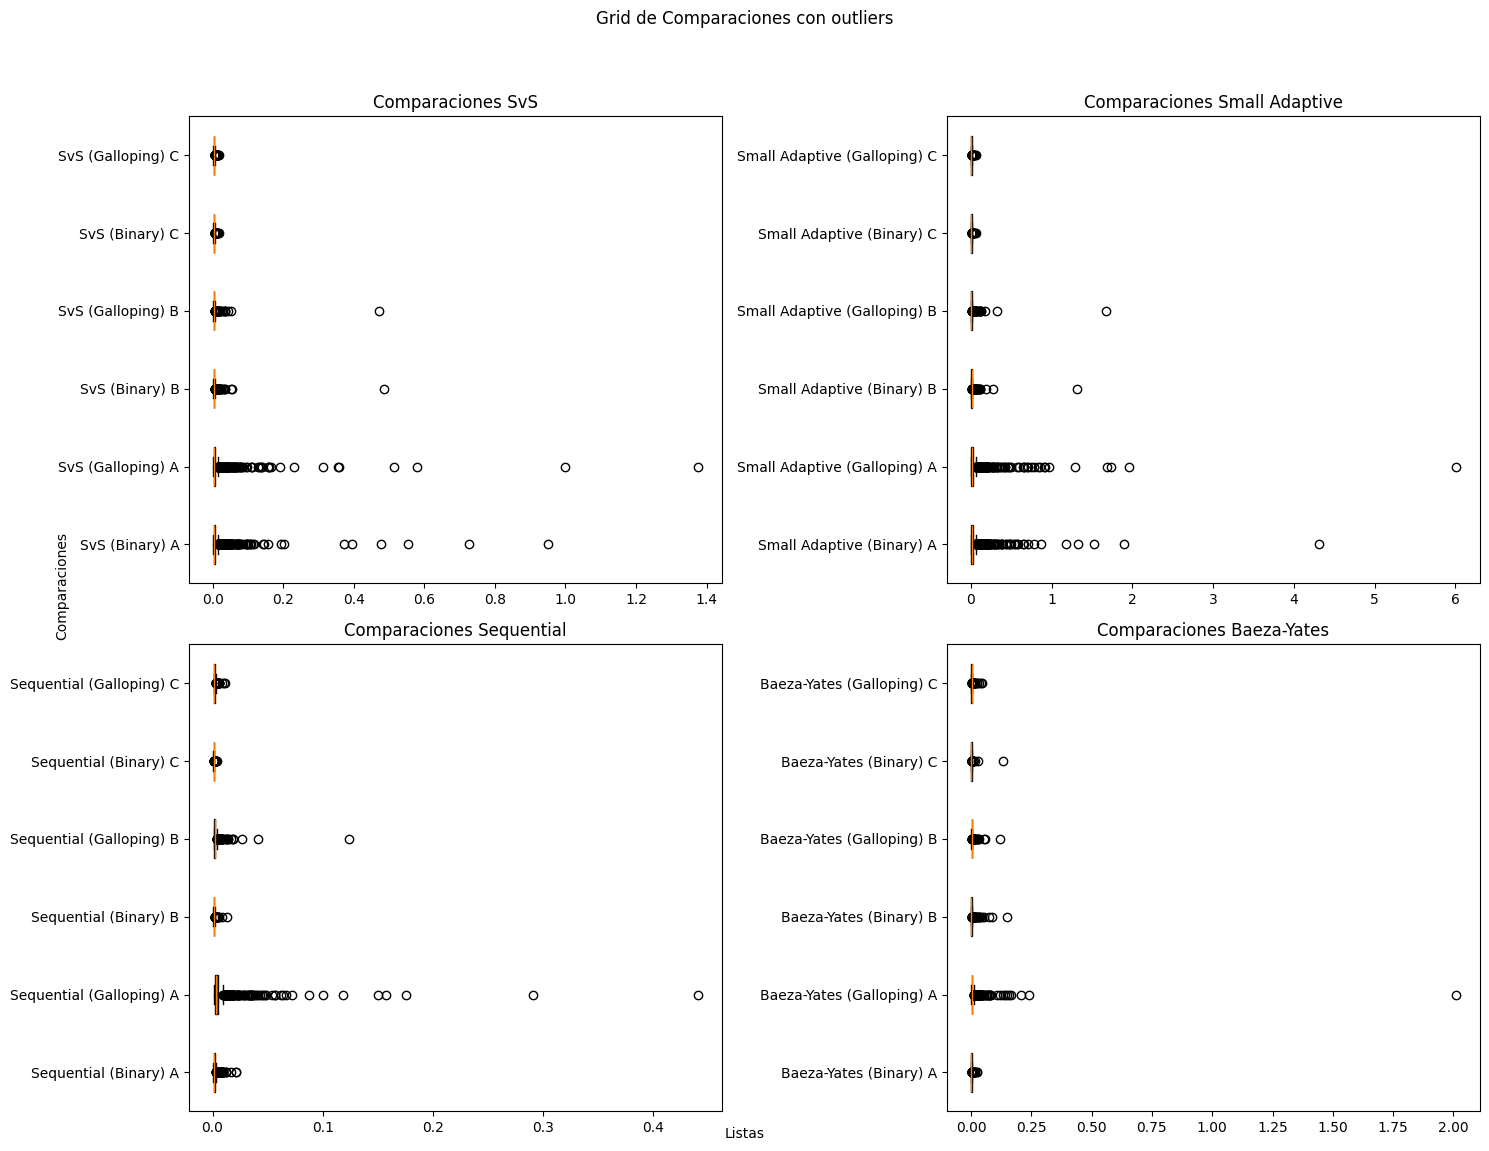

In [47]:
# Datos de comparaciones
comparaciones_svs = [comparaciones_svsb_A, comparaciones_svsg_A, comparaciones_svsb_B, comparaciones_svsg_B, comparaciones_svsb_C, comparaciones_svsg_C]
comparaciones_small_adaptive = [comparaciones_sab_A, comparaciones_sag_A, comparaciones_sab_B, comparaciones_sag_B, comparaciones_sab_C, comparaciones_sag_C]
comparaciones_sequential = [comparaciones_seqb_A, comparaciones_seqg_A, comparaciones_seqb_B, comparaciones_seqg_B, comparaciones_seqb_C, comparaciones_seqg_C]
comparaciones_baezayates = [comparaciones_bayb_A, comparaciones_bayg_A, comparaciones_bayb_B, comparaciones_bayg_B, comparaciones_bayb_C, comparaciones_bayg_C]

# Etiquetas para cada conjunto de datos
labels_svs = ['SvS (Binary) A', 'SvS (Galloping) A', 'SvS (Binary) B', 'SvS (Galloping) B', 'SvS (Binary) C', 'SvS (Galloping) C']
labels_small_adaptive = ['Small Adaptive (Binary) A', 'Small Adaptive (Galloping) A', 'Small Adaptive (Binary) B', 'Small Adaptive (Galloping) B', 'Small Adaptive (Binary) C', 'Small Adaptive (Galloping) C']
labels_sequential = ['Sequential (Binary) A', 'Sequential (Galloping) A', 'Sequential (Binary) B', 'Sequential (Galloping) B', 'Sequential (Binary) C', 'Sequential (Galloping) C']
labels_baezayates = ['Baeza-Yates (Binary) A', 'Baeza-Yates (Galloping) A', 'Baeza-Yates (Binary) B', 'Baeza-Yates (Galloping) B', 'Baeza-Yates (Binary) C', 'Baeza-Yates (Galloping) C']

# Crear el grid de subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Añadir boxplots a cada subplot
axs[0, 0].boxplot(comparaciones_svs, vert=False, patch_artist=True, labels=labels_svs, showfliers=True)
axs[0, 0].set_title('Comparaciones SvS')

axs[0, 1].boxplot(comparaciones_small_adaptive, vert=False, patch_artist=True, labels=labels_small_adaptive, showfliers=True)
axs[0, 1].set_title('Comparaciones Small Adaptive')

axs[1, 0].boxplot(comparaciones_sequential, vert=False, patch_artist=True, labels=labels_sequential, showfliers=True)
axs[1, 0].set_title('Comparaciones Sequential')

axs[1, 1].boxplot(comparaciones_baezayates, vert=False, patch_artist=True, labels=labels_baezayates, showfliers=True)
axs[1, 1].set_title('Comparaciones Baeza-Yates')

# Añadir etiquetas comunes
fig.suptitle('Grid de Comparaciones con outliers')
fig.text(0.5, 0.04, 'Listas', ha='center')
fig.text(0.04, 0.5, 'Comparaciones', va='center', rotation='vertical')

# Ajustar el layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Mostrar el gráfico
plt.show()

**Conclusión**

El algoritmo **SvS** presenta un comportamiento bastante estable en términos de longitudes de las listas resultantes. Sin embargo, en cuanto a tiempos de ejecución y número de comparaciones, muestra una variabilidad considerable dependiendo de la combinación con los algoritmos de búsqueda. Esto sugiere que SvS puede ser eficiente en términos de la cantidad de elementos que encuentra, pero su rendimiento general puede verse afectado por la estrategia de búsqueda utilizada.

**Small Adaptive** se destaca por su adaptabilidad, lo que se refleja en una menor variabilidad en los resultados en comparación con otros algoritmos. Sin embargo, en algunos casos, puede presentar un mayor número de comparaciones, lo que podría impactar su rendimiento en conjuntos de datos muy grandes.

El algoritmo **Sequential** es generalmente el más sencillo de implementar, pero también tiende a ser el menos eficiente en términos de tiempo de ejecución y número de comparaciones. Esto se debe a que examina cada elemento de ambas listas de forma independiente, lo que puede llevar a un gran número de operaciones innecesarias.

**Baeza-Yates** es un algoritmo más sofisticado que busca optimizar el número de comparaciones. Los resultados muestran que, en general, este algoritmo realiza menos comparaciones que otros, lo que se traduce en tiempos de ejecución más cortos. Sin embargo, su complejidad algorítmica puede hacer que sea menos intuitivo de implementar y ajustar.

La elección del algoritmo de búsqueda (**Binary** o **Galloping**) no parece tener un impacto significativo en el rendimiento general de los algoritmos de intersección. La teoría dice que la búsqueda binaria suele ser más eficiente en términos de número de comparaciones cuando los datos están ordenados, mientras que la búsqueda por galloping puede ser más adecuada para datos desordenados o cuando se buscan elementos que están cerca uno del otro.